In [85]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Conv2D, MaxPool2D,AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd

In [141]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [10]:
def min_max_normalization(x,lst,i): #검정색일 수록 높은 숫자이도록
    return 255 - int(( (x-min(lst[i]))/(max(lst[i]) - min(lst[i])) )*255)


#def function_name(var_name: var_type) -> return_type:
''' csv 파일을 넣으면 당일날 포함 과거 7개의 데이터를 layered한 데이터를 return 해준다
단, 첫번째에서 6번째까지는 과거의 기록이 없기에 그냥 같은 층으로 연장시켜 준다 (17, 14) 사이즈로'''
'''So please unpacking this function in two img and label'''
def make_layered_img(correct_file_name : str) -> list: #return이 list두개임
    row_data_frame = pd.read_csv("/content/gdrive/My Drive/data_ton/"+correct_file_name+".csv", encoding = 'cp949',low_memory=False)
    row_data_frame.columns = ['label',0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16] #string -> int
    #Normalization 해주고 255 픽셀화를 해주자
    data_set = []
    for idx in row_data_frame.index:
        data_set.append([])
        for time in row_data_frame.columns[1:]: #아래 방향으로 뽑아냄    
            data_set[idx].append(row_data_frame[time][idx])
    
    for lst_num in range (0,len(data_set)):
        #print(lst_num)<- error가 날때 검사용 
        data_set[lst_num] = list(map(lambda x: min_max_normalization(x,data_set,lst_num), data_set[lst_num])) 
    
    #에러 방지 코드
    if len(row_data_frame["label"]) != len(data_set):
        print('The make_layer_img has errors So, return [""],[""] ')
        return [], []
    else:
        print(" The make_layer_img function Successfully already, now make img \n")        
        print(len(data_set))
    # layered img를 만들어주자
    img_lst = []
    label_lst = []
    for data_idx in range (0, len(data_set)):
        #print(data_idx)
        tmp_img = [] #방을 만들어주기
        
        #먼저 예외 처리 (과거의 데이터가 5개가 되지 않을 경우)
        if data_idx < 6: # 0~ 5 -> 최대 개수 5일때 6개
            for _ in range (0,14):
                tmp_img.append(data_set[data_idx])
            
        else:
            #이 부분에서 데이터가 한개가 빠짐
            if data_idx == len(data_set)-1: #마지막놈은 다음 놈의 label이없으니깐
                                          #<- 애초에 이미지 데이터를 만들지 않겠다
                print("The length of img : ", len(img_lst), "The length of label label", len(label_lst))
                print("Success for makinng img and label \nSo please unpacking with img,label")
                return np.array(img_lst),np.array(label_lst) # 함수가 끝나는 지점 
                    
            for di in range (data_idx-6,data_idx+1): # data_idx -6 ~ data_idx 까지
                #같은 레이어 두개씩 쌓기
                tmp_img.append(data_set[di])
                tmp_img.append(data_set[di]) 
                 
                
        label_lst.append(row_data_frame["label"][data_idx+1]) #다음녀석의 label을 idx로 사용
        img_lst.append(np.array(tmp_img))
        
    return print("Something is Wrong with make_layered img") #위에 if문에 걸리지 않았음

In [12]:
img_set,label_set = make_layered_img("correct_data")
real_label_name, count = np.unique(label_set,return_counts = True) #진짜 label명을 따로 저장하기 [0~13]으로 이름 다시 매길거여서

 The make_layer_img function Successfully already, now make img 

1782
The length of img :  1781 The length of label label 1781
Success for makinng img and label 
So please unpacking with img,label


# 모델을 위해 데이터를 가공시키기 X-> 픽셀화 Y-> 카테고리화

In [13]:
#X를 픽셀화 시켜주기
print("\n------------------------------ X Pixelization (",len(img_set),",14,17,1) ------------------------------\n")
X_set = img_set.reshape(len(img_set),14,17,1)
print(X_set[6][:3])

#Y를 categorical 
print("\n---------------------------------- Y Categorical ----------------------------------\n")
model_label_set = []
for i in range (0,len(label_set)):
    if label_set[i] == 6:
        model_label_set.append(0)
    else:
        model_label_set.append(label_set[i]-7)
a, count = np.unique(model_label_set,return_counts = True)
b, count2 = np.unique(label_set,return_counts = True)


print("Before Categorical : ",model_label_set[0])
from tensorflow.keras.utils import to_categorical
Y_set = to_categorical(model_label_set, 14)
print("After Categorical : ", Y_set[0])
print("Real_time_set     : ",b)
print("model_label_set  : ",a)


------------------------------ X Pixelization ( 1781 ,14,17,1) ------------------------------

[[[255]
  [247]
  [228]
  [184]
  [159]
  [141]
  [128]
  [ 69]
  [ 32]
  [  0]
  [ 20]
  [ 48]
  [ 74]
  [ 54]
  [ 77]
  [128]
  [184]]

 [[255]
  [247]
  [228]
  [184]
  [159]
  [141]
  [128]
  [ 69]
  [ 32]
  [  0]
  [ 20]
  [ 48]
  [ 74]
  [ 54]
  [ 77]
  [128]
  [184]]

 [[255]
  [224]
  [227]
  [169]
  [124]
  [111]
  [ 49]
  [ 50]
  [ 47]
  [  0]
  [ 41]
  [123]
  [157]
  [161]
  [197]
  [209]
  [238]]]

---------------------------------- Y Categorical ----------------------------------

Before Categorical :  8
After Categorical :  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Real_time_set     :  [ 6  8  9 10 11 12 13 14 15 16 17 18 19 20]
model_label_set  :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


# 데이터 검증

In [15]:
#실제 그림에서 찾고 싶으면 x축에 6을 더하고 (6~22 -> 0~16) 7을 빼주면(8~20 -> 1~13) 된다, 즉 x에서 -1을 해주면 label이 나온다
print(Y_set[10])
#plt.imshow(X_set[10])#,cmap= "gray")

#즉 이 경우 9 이므로 다음 놈이 10에서 가장 찐할 것이다 이 그림의 맨 밑이랑 상관 x

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


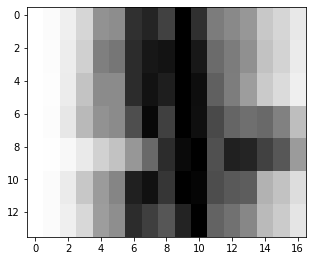

In [21]:
#실제 그림에서 찾고 싶으면 x축에 6을 더하고 (6~22 -> 0~16) 7을 빼주면(8~20 -> 1~13) 된다, 즉 x에서 -1을 해주면 label이 나온다
print(Y_set[10])
plt.figure(figsize = (5,5))
plt.imshow(X_set[13].reshape(14,17),cmap= "gray")
#즉 이 경우 9 이므로 다음 놈이 10에서 가장 찐할 것이다 이 그림의 맨 밑이랑 상관 x

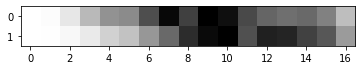

In [ ]:
plt.imshow(X_set[11][11:13],cmap= "gray")

In [22]:
X_set[11][13] 

array([[255],
       [254],
       [248],
       [234],
       [209],
       [194],
       [151],
       [105],
       [ 45],
       [ 10],
       [  0],
       [ 80],
       [ 33],
       [ 37],
       [ 66],
       [ 87],
       [155]])

# Train과 Test set 나누기

In [23]:
if (len(X_set) == len(Y_set)): #나누기전에 확인하는 조건 
    
    ######################
    PER_TRAIN = 0.8 #Train 과 Test 8:2 로 나누겠다는 소리
    ######################
    
    X_train, Y_train = X_set[:int(len(X_set)*PER_TRAIN)], Y_set[:int(len(X_set)*PER_TRAIN)]
    X_test, Y_test = X_set[int(len(X_set)*PER_TRAIN):], Y_set[int(len(X_set)*PER_TRAIN):]
    print(len(X_train),len(Y_train),len(X_test),len(Y_test))

1424 1424 357 357


In [24]:
print(X_train.shape)
print(Y_train.shape)

(1424, 14, 17, 1)
(1424, 14)


# Base Model 만들기

In [92]:
img_height = 14
img_width = 17
model = Sequential()

model.add(layers.BatchNormalization(input_shape=(img_height, img_width , 1)))
model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), padding="same", activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu'))

model.add(MaxPool2D(pool_size=(5, 5)))
model.add(Flatten())

model.add(layers.Dense(14, activation='softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_52 (Bat  (None, 14, 17, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_56 (Conv2D)          (None, 14, 17, 16)        416       
                                                                 
 batch_normalization_53 (Bat  (None, 14, 17, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_57 (Conv2D)          (None, 14, 17, 32)        12832     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 2, 3, 32)         0         
 g2D)                                                            
                                                     

In [93]:
#전체 1424 개
classifier = model.fit(X_train, Y_train, batch_size=64, epochs=40, validation_split=0.2)

Epoch 1/40
18/18 [==============================] - 3s 123ms/step - loss: 3.0092 - accuracy: 0.3960 - val_loss: 4.2830 - val_accuracy: 0.3474
Epoch 2/40
18/18 [==============================] - 1s 75ms/step - loss: 1.4463 - accuracy: 0.5136 - val_loss: 2.7550 - val_accuracy: 0.1053
Epoch 3/40
18/18 [==============================] - 1s 74ms/step - loss: 1.1889 - accuracy: 0.5356 - val_loss: 2.0663 - val_accuracy: 0.1614
Epoch 4/40
18/18 [==============================] - 1s 74ms/step - loss: 1.1441 - accuracy: 0.5724 - val_loss: 1.6066 - val_accuracy: 0.2667
Epoch 5/40
18/18 [==============================] - 1s 77ms/step - loss: 1.0933 - accuracy: 0.5803 - val_loss: 1.3539 - val_accuracy: 0.4386
Epoch 6/40
18/18 [==============================] - 1s 76ms/step - loss: 1.0986 - accuracy: 0.5654 - val_loss: 1.4198 - val_accuracy: 0.4211
Epoch 7/40
18/18 [==============================] - 1s 74ms/step - loss: 1.0631 - accuracy: 0.5856 - val_loss: 1.6927 - val_accuracy: 0.3088
Epoch 8/40
1

12/12 - 0s - loss: 2.8334 - accuracy: 0.4846 - 128ms/epoch - 11ms/step
테스트 정확도: 0.48459383845329285


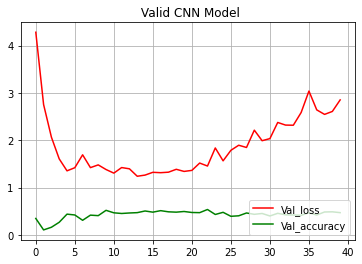

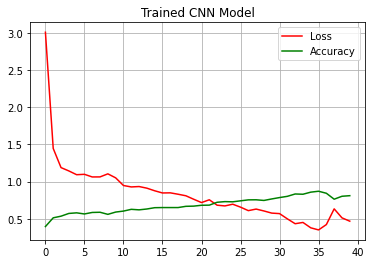

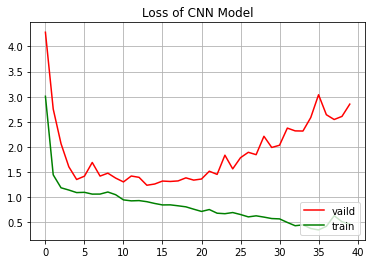

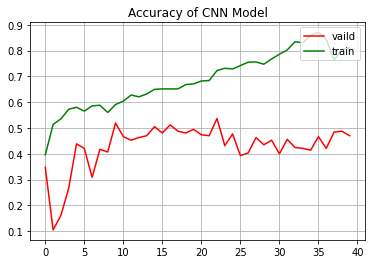

In [94]:
plt.figure()

plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['val_accuracy'], 'g')
plt.grid()
plt.title(' Valid CNN Model')
plt.legend(['Val_loss' ,'Val_accuracy'], loc='lower right')

plt.figure()
plt.plot(classifier.history['loss'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Trained CNN Model')
plt.legend(['Loss', 'Accuracy'], loc='upper right')


plt.figure()
plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['loss'], 'g')
plt.grid()
plt.title('Loss of CNN Model')
plt.legend(['vaild', 'train'], loc='lower right')

plt.figure()
plt.plot(classifier.history['val_accuracy'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Accuracy of CNN Model')
plt.legend(['vaild', 'train'], loc='upper right')


# test
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction = model.predict(X_test)

In [54]:
#전체 1424 개
classifier = model.fit(X_train, Y_train, batch_size=64, epochs=100, validation_split=0.2)

Epoch 1/100
18/18 [==============================] - 2s 90ms/step - loss: 3.0559 - accuracy: 0.4241 - val_loss: 4.3689 - val_accuracy: 0.0105
Epoch 2/100
18/18 [==============================] - 1s 74ms/step - loss: 1.5247 - accuracy: 0.4890 - val_loss: 2.9268 - val_accuracy: 0.3298
Epoch 3/100
18/18 [==============================] - 2s 96ms/step - loss: 1.2697 - accuracy: 0.5303 - val_loss: 3.3030 - val_accuracy: 0.2421
Epoch 4/100
18/18 [==============================] - 1s 75ms/step - loss: 1.1702 - accuracy: 0.5452 - val_loss: 2.3851 - val_accuracy: 0.4737
Epoch 5/100
18/18 [==============================] - 1s 76ms/step - loss: 1.0787 - accuracy: 0.5637 - val_loss: 2.0297 - val_accuracy: 0.3509
Epoch 6/100
18/18 [==============================] - 1s 74ms/step - loss: 1.0674 - accuracy: 0.5724 - val_loss: 1.5859 - val_accuracy: 0.5263
Epoch 7/100
18/18 [==============================] - 1s 75ms/step - loss: 1.0347 - accuracy: 0.5821 - val_loss: 1.7398 - val_accuracy: 0.4175
Epoch 

12/12 - 0s - loss: 4.4006 - accuracy: 0.5574 - 138ms/epoch - 11ms/step
테스트 정확도: 0.5574229955673218


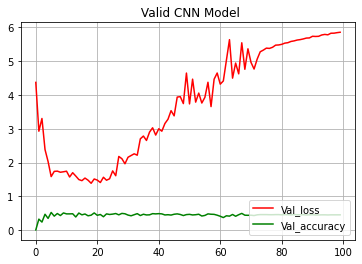

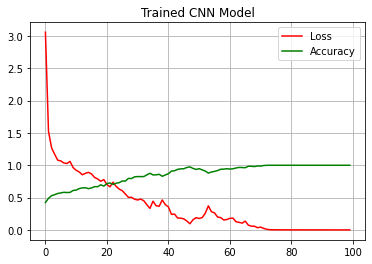

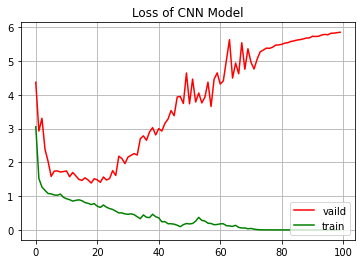

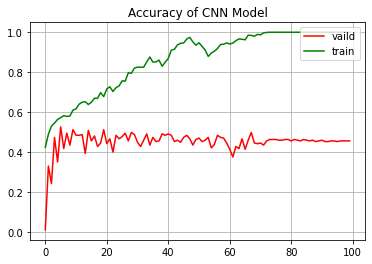

In [55]:
plt.figure()

plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['val_accuracy'], 'g')
plt.grid()
plt.title(' Valid CNN Model')
plt.legend(['Val_loss' ,'Val_accuracy'], loc='lower right')

plt.figure()
plt.plot(classifier.history['loss'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Trained CNN Model')
plt.legend(['Loss', 'Accuracy'], loc='upper right')


plt.figure()
plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['loss'], 'g')
plt.grid()
plt.title('Loss of CNN Model')
plt.legend(['vaild', 'train'], loc='lower right')

plt.figure()
plt.plot(classifier.history['val_accuracy'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Accuracy of CNN Model')
plt.legend(['vaild', 'train'], loc='upper right')


# test
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction = model.predict(X_test)

# Kernel 을 (3 x 3)으로 바꿔보기 -> 사용 x

In [37]:
img_height = 14
img_width = 17
model = Sequential()

model.add(layers.BatchNormalization(input_shape=(img_height, img_width , 1)))
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu'))

model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Flatten())

model.add(layers.Dense(14, activation='softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_11 (Bat  (None, 14, 17, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 17, 16)        160       
                                                                 
 batch_normalization_12 (Bat  (None, 14, 17, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 17, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 5, 32)         0         
 2D)                                                             
                                                      

In [38]:
#전체 1424 개
classifier = model.fit(X_train, Y_train, batch_size=64, epochs=100, validation_split=0.2)

Epoch 1/100
18/18 [==============================] - 3s 86ms/step - loss: 2.1164 - accuracy: 0.4170 - val_loss: 1.4415 - val_accuracy: 0.4947
Epoch 2/100
18/18 [==============================] - 1s 57ms/step - loss: 1.3057 - accuracy: 0.5645 - val_loss: 1.7853 - val_accuracy: 0.4807
Epoch 3/100
18/18 [==============================] - 1s 38ms/step - loss: 1.1496 - accuracy: 0.5514 - val_loss: 1.9897 - val_accuracy: 0.4596
Epoch 4/100
18/18 [==============================] - 1s 37ms/step - loss: 1.0412 - accuracy: 0.5865 - val_loss: 2.1365 - val_accuracy: 0.4772
Epoch 5/100
18/18 [==============================] - 1s 38ms/step - loss: 0.9942 - accuracy: 0.6005 - val_loss: 2.3179 - val_accuracy: 0.4632
Epoch 6/100
18/18 [==============================] - 1s 38ms/step - loss: 0.9398 - accuracy: 0.6198 - val_loss: 2.2620 - val_accuracy: 0.3509
Epoch 7/100
18/18 [==============================] - 1s 40ms/step - loss: 0.8950 - accuracy: 0.6339 - val_loss: 2.2021 - val_accuracy: 0.3614
Epoch 

12/12 - 1s - loss: 10.1812 - accuracy: 0.2213 - 683ms/epoch - 57ms/step
테스트 정확도: 0.2212885171175003


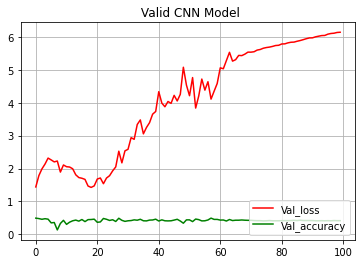

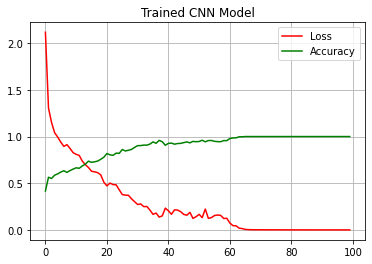

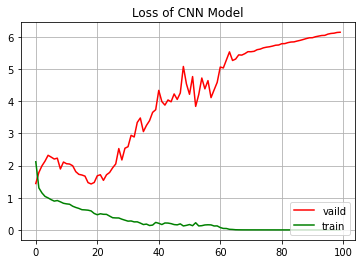

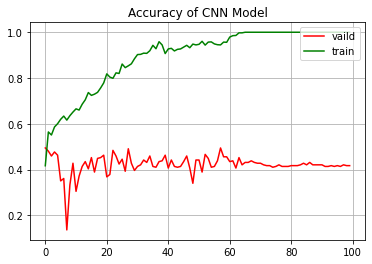

In [40]:
plt.figure()

plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['val_accuracy'], 'g')
plt.grid()
plt.title(' Valid CNN Model')
plt.legend(['Val_loss' ,'Val_accuracy'], loc='lower right')

plt.figure()
plt.plot(classifier.history['loss'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Trained CNN Model')
plt.legend(['Loss', 'Accuracy'], loc='upper right')


plt.figure()
plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['loss'], 'g')
plt.grid()
plt.title('Loss of CNN Model')
plt.legend(['vaild', 'train'], loc='lower right')

plt.figure()
plt.plot(classifier.history['val_accuracy'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Accuracy of CNN Model')
plt.legend(['vaild', 'train'], loc='upper right')


# test
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction = model.predict(X_test)

# base 모델 수정(맨앞에 batch 정규화가 불필요하다 생각) -> 필요하네 ㅎㅎ

In [42]:
img_height = 14
img_width = 17
model = Sequential()

model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), padding="same", activation= 'relu',input_shape=(img_height, img_width , 1)))

model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu'))

model.add(MaxPool2D(pool_size=(5, 5)))
model.add(Flatten())

model.add(layers.Dense(14, activation='softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 14, 17, 16)        416       
                                                                 
 batch_normalization_17 (Bat  (None, 14, 17, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_18 (Conv2D)          (None, 14, 17, 32)        12832     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 2, 3, 32)         0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 192)               0         
                                                                 
 dense_7 (Dense)             (None, 14)               

In [47]:
#전체 1424 개
classifier = model.fit(X_train, Y_train, batch_size=64, epochs=40, validation_split=0.2)

Epoch 1/40
18/18 [==============================] - 1s 80ms/step - loss: 1.2258 - accuracy: 0.5601 - val_loss: 1.6841 - val_accuracy: 0.4737
Epoch 2/40
18/18 [==============================] - 1s 82ms/step - loss: 1.1999 - accuracy: 0.5294 - val_loss: 1.4151 - val_accuracy: 0.5158
Epoch 3/40
18/18 [==============================] - 2s 122ms/step - loss: 1.0760 - accuracy: 0.5786 - val_loss: 1.5680 - val_accuracy: 0.5263
Epoch 4/40
18/18 [==============================] - 2s 137ms/step - loss: 1.0543 - accuracy: 0.5751 - val_loss: 1.5911 - val_accuracy: 0.5263
Epoch 5/40
18/18 [==============================] - 1s 74ms/step - loss: 1.0836 - accuracy: 0.5777 - val_loss: 1.5702 - val_accuracy: 0.5158
Epoch 6/40
18/18 [==============================] - 1s 74ms/step - loss: 1.0241 - accuracy: 0.6023 - val_loss: 1.7531 - val_accuracy: 0.4281
Epoch 7/40
18/18 [==============================] - 1s 74ms/step - loss: 1.0015 - accuracy: 0.6084 - val_loss: 1.6206 - val_accuracy: 0.4842
Epoch 8/40


12/12 - 0s - loss: 2.6376 - accuracy: 0.3389 - 122ms/epoch - 10ms/step
테스트 정확도: 0.33893558382987976


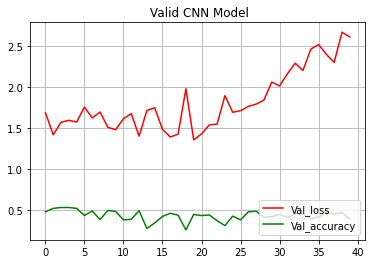

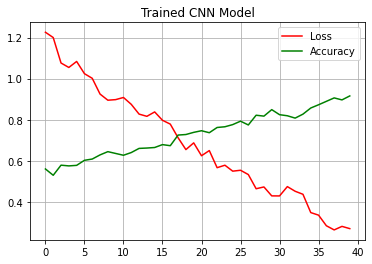

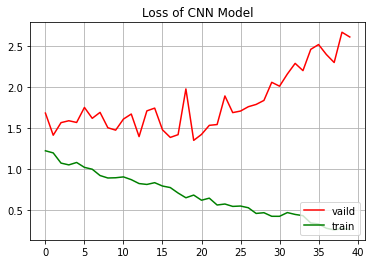

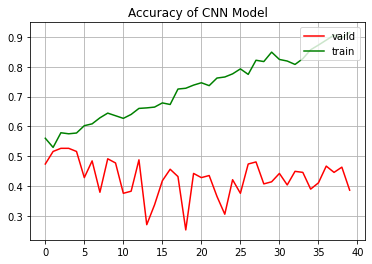

In [49]:
plt.figure()

plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['val_accuracy'], 'g')
plt.grid()
plt.title(' Valid CNN Model')
plt.legend(['Val_loss' ,'Val_accuracy'], loc='lower right')

plt.figure()
plt.plot(classifier.history['loss'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Trained CNN Model')
plt.legend(['Loss', 'Accuracy'], loc='upper right')


plt.figure()
plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['loss'], 'g')
plt.grid()
plt.title('Loss of CNN Model')
plt.legend(['vaild', 'train'], loc='lower right')

plt.figure()
plt.plot(classifier.history['val_accuracy'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Accuracy of CNN Model')
plt.legend(['vaild', 'train'], loc='upper right')


# test
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction = model.predict(X_test)

In [ ]:
#

#Base model 수정하기(중간에 kernel 바꿔봄) -> 안하는데에는 이유가 있다

In [59]:
img_height = 14
img_width = 17
model = Sequential()

model.add(layers.BatchNormalization(input_shape=(img_height, img_width , 1)))
model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), padding="same", activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu'))

model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Flatten())

model.add(layers.Dense(14, activation='softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_30 (Bat  (None, 14, 17, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_31 (Conv2D)          (None, 14, 17, 16)        416       
                                                                 
 batch_normalization_31 (Bat  (None, 14, 17, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_32 (Conv2D)          (None, 14, 17, 32)        4640      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 4, 5, 32)         0         
 g2D)                                                            
                                                     

Epoch 1/40
18/18 [==============================] - 3s 91ms/step - loss: 2.6855 - accuracy: 0.3977 - val_loss: 2.3278 - val_accuracy: 0.1228
Epoch 2/40
18/18 [==============================] - 1s 43ms/step - loss: 1.3309 - accuracy: 0.5391 - val_loss: 1.9494 - val_accuracy: 0.5298
Epoch 3/40
18/18 [==============================] - 1s 42ms/step - loss: 1.2173 - accuracy: 0.5435 - val_loss: 1.9156 - val_accuracy: 0.4386
Epoch 4/40
18/18 [==============================] - 1s 42ms/step - loss: 1.1853 - accuracy: 0.5417 - val_loss: 1.5390 - val_accuracy: 0.5158
Epoch 5/40
18/18 [==============================] - 1s 42ms/step - loss: 1.0745 - accuracy: 0.5549 - val_loss: 1.4298 - val_accuracy: 0.5333
Epoch 6/40
18/18 [==============================] - 1s 43ms/step - loss: 1.1008 - accuracy: 0.5707 - val_loss: 1.4273 - val_accuracy: 0.5053
Epoch 7/40
18/18 [==============================] - 1s 43ms/step - loss: 1.0371 - accuracy: 0.5891 - val_loss: 1.2689 - val_accuracy: 0.5649
Epoch 8/40
18

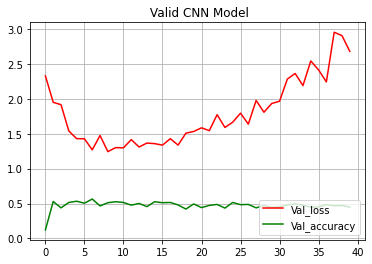

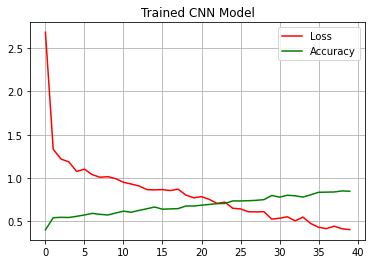

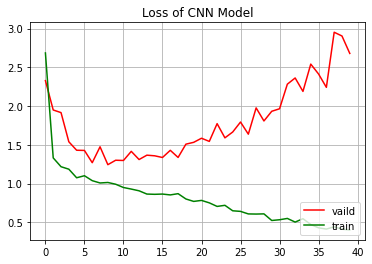

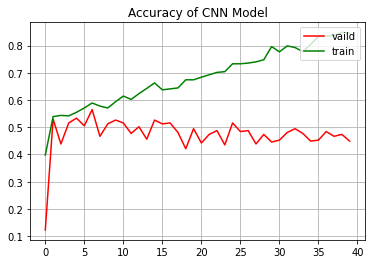

In [60]:
#전체 1424 개
classifier = model.fit(X_train, Y_train, batch_size=64, epochs=40, validation_split=0.2)
plt.figure()

plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['val_accuracy'], 'g')
plt.grid()
plt.title(' Valid CNN Model')
plt.legend(['Val_loss' ,'Val_accuracy'], loc='lower right')

plt.figure()
plt.plot(classifier.history['loss'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Trained CNN Model')
plt.legend(['Loss', 'Accuracy'], loc='upper right')


plt.figure()
plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['loss'], 'g')
plt.grid()
plt.title('Loss of CNN Model')
plt.legend(['vaild', 'train'], loc='lower right')

plt.figure()
plt.plot(classifier.history['val_accuracy'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Accuracy of CNN Model')
plt.legend(['vaild', 'train'], loc='upper right')


# test
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction = model.predict(X_test)

# LeNET

In [62]:
img_height = 14
img_width = 17
model = Sequential()
#L1
model.add(layers.BatchNormalization(input_shape=(img_height, img_width , 1)))
model.add(layers.Conv2D(filters=6, kernel_size=(5, 5),strides= 1, padding="same", activation='relu'))
#L2
model.add(AvgPool2D(pool_size=(2, 2), strides = 2))
#L3
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), padding="same", activation='relu'))
#L4
model.add(AvgPool2D(pool_size=(2, 2), strides = 2))
#L5
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=120, strides = 1,kernel_size=(5, 5), padding="same", activation='relu'))
#L6
model.add(Flatten())
model.add(layers.Dense(84,activation='tanh'))
model.add(layers.Dense(14, activation='softmax'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_32 (Bat  (None, 14, 17, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_33 (Conv2D)          (None, 14, 17, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 7, 8, 6)          0         
 ooling2D)                                                       
                                                                 
 batch_normalization_33 (Bat  (None, 7, 8, 6)          24        
 chNormalization)                                                
                                                                 
 conv2d_34 (Conv2D)          (None, 7, 8, 16)          2416      
                                                     

In [69]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])

Epoch 1/40
18/18 [==============================] - 1s 59ms/step - loss: 1.4391 - accuracy: 0.4996 - val_loss: 1.4980 - val_accuracy: 0.5298
Epoch 2/40
18/18 [==============================] - 1s 53ms/step - loss: 1.4932 - accuracy: 0.4644 - val_loss: 1.4894 - val_accuracy: 0.5298
Epoch 3/40
18/18 [==============================] - 1s 55ms/step - loss: 1.4799 - accuracy: 0.4636 - val_loss: 1.5140 - val_accuracy: 0.5298
Epoch 4/40
18/18 [==============================] - 1s 45ms/step - loss: 1.4667 - accuracy: 0.4934 - val_loss: 1.5935 - val_accuracy: 0.1228
Epoch 5/40
18/18 [==============================] - 1s 35ms/step - loss: 1.4342 - accuracy: 0.4776 - val_loss: 1.4424 - val_accuracy: 0.5298
Epoch 6/40
18/18 [==============================] - 1s 35ms/step - loss: 1.4441 - accuracy: 0.4996 - val_loss: 1.4188 - val_accuracy: 0.5298
Epoch 7/40
18/18 [==============================] - 1s 36ms/step - loss: 1.4501 - accuracy: 0.4996 - val_loss: 1.5684 - val_accuracy: 0.5298
Epoch 8/40
18

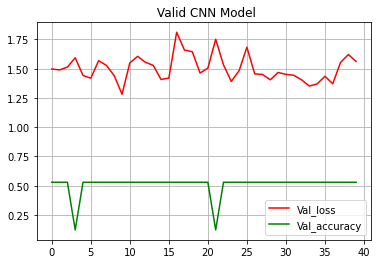

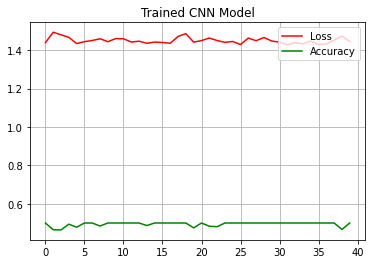

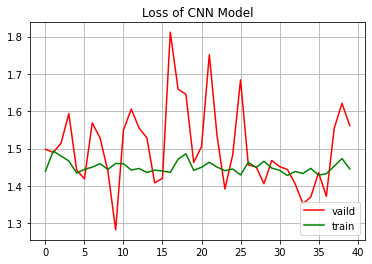

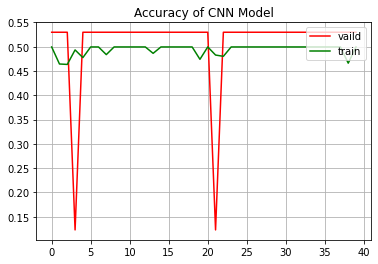

In [71]:
#전체 1424 개
classifier = model.fit(X_train, Y_train, batch_size=64, epochs=40, validation_split=0.2)
plt.figure()

plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['val_accuracy'], 'g')
plt.grid()
plt.title(' Valid CNN Model')
plt.legend(['Val_loss' ,'Val_accuracy'], loc='lower right')

plt.figure()
plt.plot(classifier.history['loss'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Trained CNN Model')
plt.legend(['Loss', 'Accuracy'], loc='upper right')


plt.figure()
plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['loss'], 'g')
plt.grid()
plt.title('Loss of CNN Model')
plt.legend(['vaild', 'train'], loc='lower right')

plt.figure()
plt.plot(classifier.history['val_accuracy'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Accuracy of CNN Model')
plt.legend(['vaild', 'train'], loc='upper right')


# test
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction = model.predict(X_test)

In [72]:
# test
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction = model.predict(X_test)

12/12 - 0s - loss: 1.3199 - accuracy: 0.6331 - 183ms/epoch - 15ms/step
테스트 정확도: 0.6330532431602478


In [75]:
#  Non

# VGG11 (3x3)

In [78]:
img_height = 14
img_width = 17
model = Sequential()

model.add(layers.Conv2D(filters = 64, kernel_size=(3, 3), padding="same", activation= 'relu',input_shape=(img_height, img_width , 1)))
model.add(MaxPool2D(pool_size=(3, 3)))

model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(MaxPool2D(pool_size=(3, 3)))

model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation='relu'))
#model.add(MaxPool2D(pool_size=(3, 3)))

model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu'))
#model.add(MaxPool2D(pool_size=(3, 3)))

model.add(Flatten())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(14, activation='softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 14, 17, 64)        640       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 4, 5, 64)         0         
 g2D)                                                            
                                                                 
 batch_normalization_40 (Bat  (None, 4, 5, 64)         256       
 chNormalization)                                                
                                                                 
 conv2d_44 (Conv2D)          (None, 4, 5, 128)         73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 1, 1, 128)        0         
 g2D)                                                            
                                                     

Epoch 1/40
18/18 [==============================] - 8s 356ms/step - loss: 2.3645 - accuracy: 0.4337 - val_loss: 37.4830 - val_accuracy: 0.5298
Epoch 2/40
18/18 [==============================] - 5s 262ms/step - loss: 1.7079 - accuracy: 0.5040 - val_loss: 37.4109 - val_accuracy: 0.5298
Epoch 3/40
18/18 [==============================] - 5s 265ms/step - loss: 1.5056 - accuracy: 0.5198 - val_loss: 18.6143 - val_accuracy: 0.5298
Epoch 4/40
18/18 [==============================] - 5s 264ms/step - loss: 1.2363 - accuracy: 0.5461 - val_loss: 21.7138 - val_accuracy: 0.1228
Epoch 5/40
18/18 [==============================] - 7s 372ms/step - loss: 1.1663 - accuracy: 0.5672 - val_loss: 17.2258 - val_accuracy: 0.5298
Epoch 6/40
18/18 [==============================] - 5s 264ms/step - loss: 1.1111 - accuracy: 0.5786 - val_loss: 12.5100 - val_accuracy: 0.5298
Epoch 7/40
18/18 [==============================] - 5s 266ms/step - loss: 1.0441 - accuracy: 0.5777 - val_loss: 12.7725 - val_accuracy: 0.5298

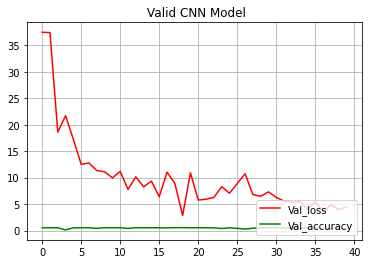

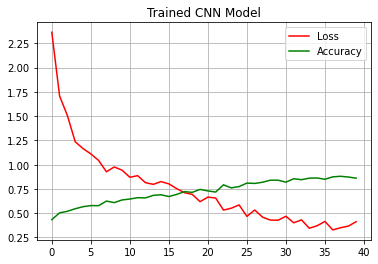

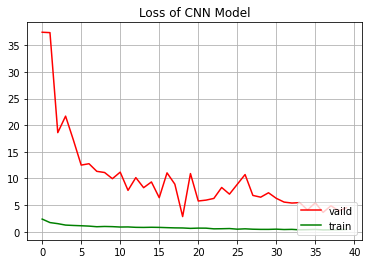

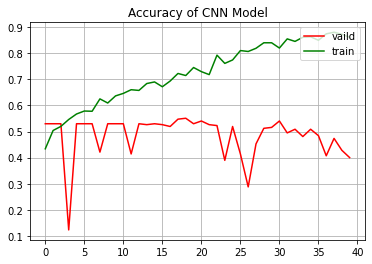

In [79]:
#전체 1424 개
classifier = model.fit(X_train, Y_train, batch_size=64, epochs=40, validation_split=0.2)
plt.figure()

plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['val_accuracy'], 'g')
plt.grid()
plt.title(' Valid CNN Model')
plt.legend(['Val_loss' ,'Val_accuracy'], loc='lower right')

plt.figure()
plt.plot(classifier.history['loss'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Trained CNN Model')
plt.legend(['Loss', 'Accuracy'], loc='upper right')


plt.figure()
plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['loss'], 'g')
plt.grid()
plt.title('Loss of CNN Model')
plt.legend(['vaild', 'train'], loc='lower right')

plt.figure()
plt.plot(classifier.history['val_accuracy'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Accuracy of CNN Model')
plt.legend(['vaild', 'train'], loc='upper right')


# test
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction = model.predict(X_test)

In [80]:
# test
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction = model.predict(X_test)

12/12 - 0s - loss: 2.9754 - accuracy: 0.3277 - 125ms/epoch - 10ms/step
테스트 정확도: 0.32773110270500183


#Base model 바꾸기 average pooling 으로

In [89]:
img_height = 14
img_width = 17
model = Sequential()

model.add(layers.BatchNormalization(input_shape=(img_height, img_width , 1)))
model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), padding="same", activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu'))

model.add(AveragePooling2D(pool_size=(5, 5)))
model.add(Flatten())

model.add(layers.Dense(14, activation='softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_50 (Bat  (None, 14, 17, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_54 (Conv2D)          (None, 14, 17, 16)        416       
                                                                 
 batch_normalization_51 (Bat  (None, 14, 17, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_55 (Conv2D)          (None, 14, 17, 32)        12832     
                                                                 
 average_pooling2d_3 (Averag  (None, 2, 3, 32)         0         
 ePooling2D)                                                     
                                                     

Epoch 1/40
18/18 [==============================] - 2s 85ms/step - loss: 1.8080 - accuracy: 0.4100 - val_loss: 1.8682 - val_accuracy: 0.2912
Epoch 2/40
18/18 [==============================] - 1s 73ms/step - loss: 1.3254 - accuracy: 0.5075 - val_loss: 1.6381 - val_accuracy: 0.2737
Epoch 3/40
18/18 [==============================] - 1s 73ms/step - loss: 1.1938 - accuracy: 0.5478 - val_loss: 1.9868 - val_accuracy: 0.1404
Epoch 4/40
18/18 [==============================] - 1s 74ms/step - loss: 1.1613 - accuracy: 0.5531 - val_loss: 1.8760 - val_accuracy: 0.1895
Epoch 5/40
18/18 [==============================] - 1s 74ms/step - loss: 1.0903 - accuracy: 0.5663 - val_loss: 1.9365 - val_accuracy: 0.2211
Epoch 6/40
18/18 [==============================] - 1s 74ms/step - loss: 1.0667 - accuracy: 0.5795 - val_loss: 1.7571 - val_accuracy: 0.4000
Epoch 7/40
18/18 [==============================] - 1s 76ms/step - loss: 1.0416 - accuracy: 0.5680 - val_loss: 1.7430 - val_accuracy: 0.4175
Epoch 8/40
18

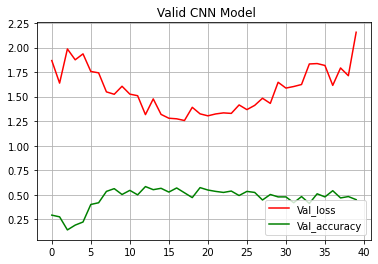

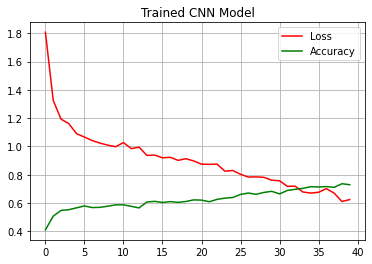

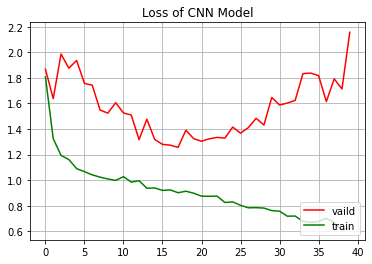

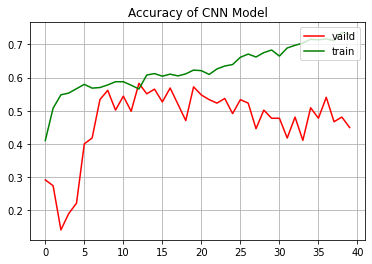

In [90]:
#전체 1424 개
classifier = model.fit(X_train, Y_train, batch_size=64, epochs=40, validation_split=0.2)
plt.figure()

plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['val_accuracy'], 'g')
plt.grid()
plt.title(' Valid CNN Model')
plt.legend(['Val_loss' ,'Val_accuracy'], loc='lower right')

plt.figure()
plt.plot(classifier.history['loss'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Trained CNN Model')
plt.legend(['Loss', 'Accuracy'], loc='upper right')


plt.figure()
plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['loss'], 'g')
plt.grid()
plt.title('Loss of CNN Model')
plt.legend(['vaild', 'train'], loc='lower right')

plt.figure()
plt.plot(classifier.history['val_accuracy'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Accuracy of CNN Model')
plt.legend(['vaild', 'train'], loc='upper right')


# test
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction = model.predict(X_test)

In [91]:
# test
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction = model.predict(X_test)

12/12 - 0s - loss: 1.9310 - accuracy: 0.5966 - 123ms/epoch - 10ms/step
테스트 정확도: 0.5966386795043945


# Conv layer 64 를 한개 더 추가

In [102]:
img_height = 14
img_width = 17
model = Sequential()

model.add(layers.BatchNormalization(input_shape=(img_height, img_width , 1)))
model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), padding="same", activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), padding="same", activation='relu'))

model.add(AveragePooling2D(pool_size=(5, 5)))
model.add(Flatten())

model.add(layers.Dense(14, activation='softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_66 (Bat  (None, 14, 17, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_70 (Conv2D)          (None, 14, 17, 16)        416       
                                                                 
 batch_normalization_67 (Bat  (None, 14, 17, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_71 (Conv2D)          (None, 14, 17, 32)        12832     
                                                                 
 batch_normalization_68 (Bat  (None, 14, 17, 32)       128       
 chNormalization)                                                
                                                     

Epoch 1/40
18/18 [==============================] - 5s 232ms/step - loss: 6.0351 - accuracy: 0.3152 - val_loss: 23.4264 - val_accuracy: 0.4035
Epoch 2/40
18/18 [==============================] - 4s 217ms/step - loss: 2.1612 - accuracy: 0.4486 - val_loss: 8.3416 - val_accuracy: 0.5193
Epoch 3/40
18/18 [==============================] - 4s 219ms/step - loss: 1.3615 - accuracy: 0.5066 - val_loss: 3.8575 - val_accuracy: 0.5298
Epoch 4/40
18/18 [==============================] - 4s 219ms/step - loss: 1.1879 - accuracy: 0.5356 - val_loss: 2.6219 - val_accuracy: 0.4070
Epoch 5/40
18/18 [==============================] - 4s 219ms/step - loss: 1.1713 - accuracy: 0.5461 - val_loss: 1.5768 - val_accuracy: 0.4596
Epoch 6/40
18/18 [==============================] - 4s 223ms/step - loss: 1.1105 - accuracy: 0.5733 - val_loss: 1.4832 - val_accuracy: 0.4491
Epoch 7/40
18/18 [==============================] - 4s 218ms/step - loss: 1.1451 - accuracy: 0.5461 - val_loss: 1.3411 - val_accuracy: 0.4842
Epoch

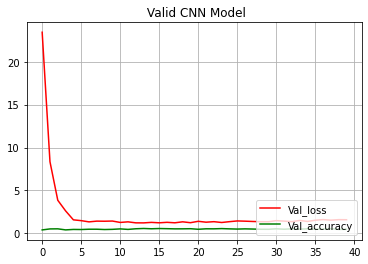

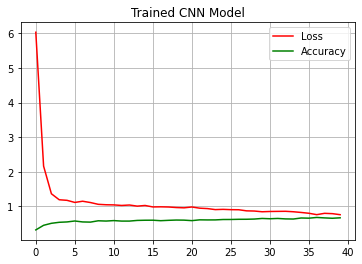

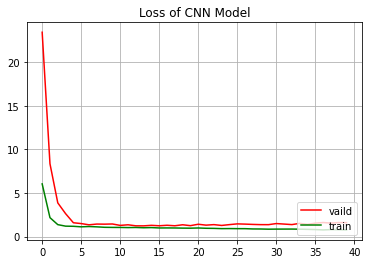

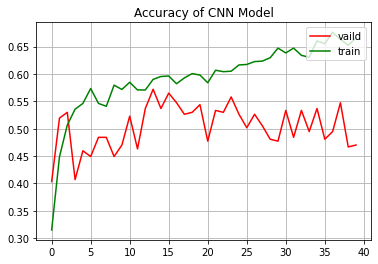

In [103]:
#전체 1424 개
classifier = model.fit(X_train, Y_train, batch_size=64, epochs=40, validation_split=0.2)
plt.figure()

plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['val_accuracy'], 'g')
plt.grid()
plt.title(' Valid CNN Model')
plt.legend(['Val_loss' ,'Val_accuracy'], loc='lower right')

plt.figure()
plt.plot(classifier.history['loss'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Trained CNN Model')
plt.legend(['Loss', 'Accuracy'], loc='upper right')


plt.figure()
plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['loss'], 'g')
plt.grid()
plt.title('Loss of CNN Model')
plt.legend(['vaild', 'train'], loc='lower right')

plt.figure()
plt.plot(classifier.history['val_accuracy'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Accuracy of CNN Model')
plt.legend(['vaild', 'train'], loc='upper right')


# test
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction = model.predict(X_test)

In [104]:

# test
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction = model.predict(X_test)

12/12 - 0s - loss: 1.3376 - accuracy: 0.6022 - 331ms/epoch - 28ms/step
테스트 정확도: 0.6022409200668335


# Conv 32 를 추가

In [101]:
img_height = 14
img_width = 17
model = Sequential()

model.add(layers.BatchNormalization(input_shape=(img_height, img_width , 1)))
model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), padding="same", activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu'))

model.add(AveragePooling2D(pool_size=(5, 5)))
model.add(Flatten())

model.add(layers.Dense(14, activation='softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_63 (Bat  (None, 14, 17, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_67 (Conv2D)          (None, 14, 17, 16)        416       
                                                                 
 batch_normalization_64 (Bat  (None, 14, 17, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_68 (Conv2D)          (None, 14, 17, 32)        12832     
                                                                 
 batch_normalization_65 (Bat  (None, 14, 17, 32)       128       
 chNormalization)                                                
                                                     

Epoch 1/40
18/18 [==============================] - 6s 232ms/step - loss: 3.0629 - accuracy: 0.3810 - val_loss: 10.0966 - val_accuracy: 0.0667
Epoch 2/40
18/18 [==============================] - 3s 174ms/step - loss: 1.5384 - accuracy: 0.4776 - val_loss: 4.4857 - val_accuracy: 0.0877
Epoch 3/40
18/18 [==============================] - 3s 177ms/step - loss: 1.2583 - accuracy: 0.5382 - val_loss: 2.4595 - val_accuracy: 0.4807
Epoch 4/40
18/18 [==============================] - 3s 177ms/step - loss: 1.1955 - accuracy: 0.5408 - val_loss: 2.5457 - val_accuracy: 0.1333
Epoch 5/40
18/18 [==============================] - 3s 178ms/step - loss: 1.1287 - accuracy: 0.5601 - val_loss: 1.6773 - val_accuracy: 0.5263
Epoch 6/40
18/18 [==============================] - 3s 175ms/step - loss: 1.0897 - accuracy: 0.5680 - val_loss: 1.3840 - val_accuracy: 0.5298
Epoch 7/40
18/18 [==============================] - 3s 178ms/step - loss: 1.0954 - accuracy: 0.5628 - val_loss: 1.4657 - val_accuracy: 0.5158
Epoch

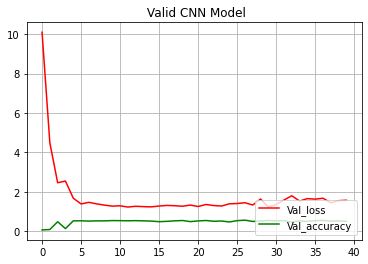

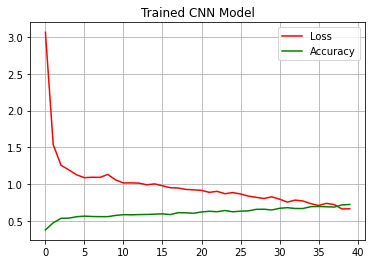

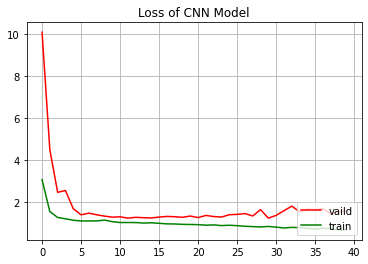

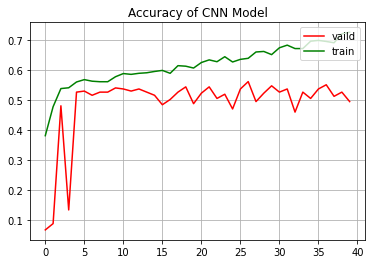

In [99]:
#전체 1424 개
classifier = model.fit(X_train, Y_train, batch_size=64, epochs=40, validation_split=0.2)
plt.figure()

plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['val_accuracy'], 'g')
plt.grid()
plt.title(' Valid CNN Model')
plt.legend(['Val_loss' ,'Val_accuracy'], loc='lower right')

plt.figure()
plt.plot(classifier.history['loss'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Trained CNN Model')
plt.legend(['Loss', 'Accuracy'], loc='upper right')


plt.figure()
plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['loss'], 'g')
plt.grid()
plt.title('Loss of CNN Model')
plt.legend(['vaild', 'train'], loc='lower right')

plt.figure()
plt.plot(classifier.history['val_accuracy'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Accuracy of CNN Model')
plt.legend(['vaild', 'train'], loc='upper right')


# test
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction = model.predict(X_test)

In [100]:
# test
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction = model.predict(X_test)

12/12 - 0s - loss: 1.4056 - accuracy: 0.5854 - 433ms/epoch - 36ms/step
테스트 정확도: 0.5854341983795166


In [105]:
img_height = 14
img_width = 17
model2 = Sequential()

model2.add(layers.BatchNormalization(input_shape=(img_height, img_width , 1)))
model2.add(layers.Conv2D(filters=16, kernel_size=(5, 5), padding="same", activation='relu'))

model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu'))

model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(filters=64, kernel_size=(5, 5), padding="same", activation='relu'))

model2.add(AveragePooling2D(pool_size=(5, 5)))
model2.add(Flatten())

model2.add(layers.Dense(14, activation='softmax'))
model2.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model2.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_69 (Bat  (None, 14, 17, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_73 (Conv2D)          (None, 14, 17, 16)        416       
                                                                 
 batch_normalization_70 (Bat  (None, 14, 17, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_74 (Conv2D)          (None, 14, 17, 32)        12832     
                                                                 
 batch_normalization_71 (Bat  (None, 14, 17, 32)       128       
 chNormalization)                                                
                                                     

Epoch 1/40
18/18 [==============================] - 7s 317ms/step - loss: 5.7136 - accuracy: 0.3301 - val_loss: 52.2786 - val_accuracy: 0.0526
Epoch 2/40
18/18 [==============================] - 4s 217ms/step - loss: 1.6912 - accuracy: 0.4592 - val_loss: 6.3871 - val_accuracy: 0.4000
Epoch 3/40
18/18 [==============================] - 4s 221ms/step - loss: 1.3055 - accuracy: 0.5180 - val_loss: 3.7969 - val_accuracy: 0.4842
Epoch 4/40
18/18 [==============================] - 4s 220ms/step - loss: 1.1842 - accuracy: 0.5443 - val_loss: 1.5482 - val_accuracy: 0.5158
Epoch 5/40
18/18 [==============================] - 4s 221ms/step - loss: 1.1230 - accuracy: 0.5461 - val_loss: 1.3800 - val_accuracy: 0.5825
Epoch 6/40
18/18 [==============================] - 4s 225ms/step - loss: 1.1080 - accuracy: 0.5601 - val_loss: 1.4574 - val_accuracy: 0.5158
Epoch 7/40
18/18 [==============================] - 4s 224ms/step - loss: 1.1148 - accuracy: 0.5566 - val_loss: 1.4954 - val_accuracy: 0.4421
Epoch

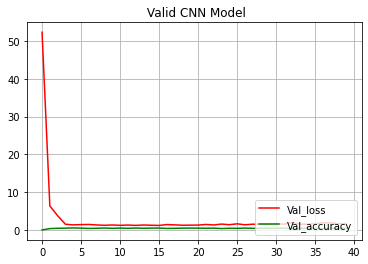

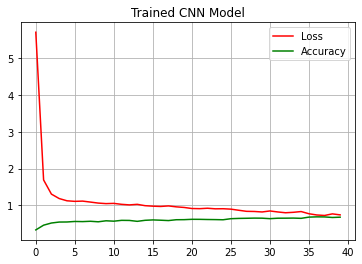

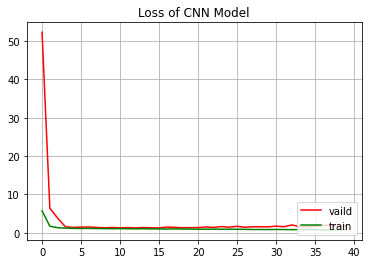

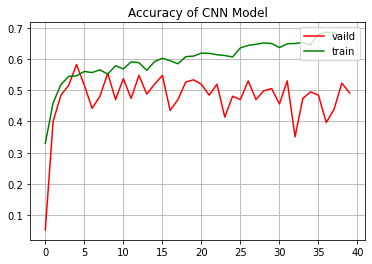

In [106]:
#전체 1424 개
classifier2 = model2.fit(X_train, Y_train, batch_size=64, epochs=40, validation_split=0.2)
plt.figure()

plt.plot(classifier2.history['val_loss'], 'r')
plt.plot(classifier2.history['val_accuracy'], 'g')
plt.grid()
plt.title(' Valid CNN Model')
plt.legend(['Val_loss' ,'Val_accuracy'], loc='lower right')

plt.figure()
plt.plot(classifier2.history['loss'], 'r')
plt.plot(classifier2.history['accuracy'], 'g')
plt.grid()
plt.title('Trained CNN Model')
plt.legend(['Loss', 'Accuracy'], loc='upper right')


plt.figure()
plt.plot(classifier2.history['val_loss'], 'r')
plt.plot(classifier2.history['loss'], 'g')
plt.grid()
plt.title('Loss of CNN Model')
plt.legend(['vaild', 'train'], loc='lower right')

plt.figure()
plt.plot(classifier2.history['val_accuracy'], 'r')
plt.plot(classifier2.history['accuracy'], 'g')
plt.grid()
plt.title('Accuracy of CNN Model')
plt.legend(['vaild', 'train'], loc='upper right')


# test
test_loss, test_acc = model2.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction2 = model2.predict(X_test)

#마지막 Pooling을 빼보자

In [107]:
# 16, 32
img_height = 14
img_width = 17
model = Sequential()

model.add(layers.BatchNormalization(input_shape=(img_height, img_width , 1)))
model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), padding="same", activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu'))

model.add(Flatten())

model.add(layers.Dense(14, activation='softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_72 (Bat  (None, 14, 17, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_76 (Conv2D)          (None, 14, 17, 16)        416       
                                                                 
 batch_normalization_73 (Bat  (None, 14, 17, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_77 (Conv2D)          (None, 14, 17, 32)        12832     
                                                                 
 flatten_27 (Flatten)        (None, 7616)              0         
                                                                 
 dense_28 (Dense)            (None, 14)              

Epoch 1/40
18/18 [==============================] - 4s 138ms/step - loss: 11.5045 - accuracy: 0.3205 - val_loss: 5.4450 - val_accuracy: 0.0982
Epoch 2/40
18/18 [==============================] - 1s 75ms/step - loss: 2.1278 - accuracy: 0.4548 - val_loss: 2.4099 - val_accuracy: 0.5298
Epoch 3/40
18/18 [==============================] - 2s 97ms/step - loss: 1.1402 - accuracy: 0.5601 - val_loss: 2.4769 - val_accuracy: 0.0421
Epoch 4/40
18/18 [==============================] - 2s 139ms/step - loss: 1.0214 - accuracy: 0.5645 - val_loss: 2.5842 - val_accuracy: 0.5298
Epoch 5/40
18/18 [==============================] - 2s 104ms/step - loss: 0.9925 - accuracy: 0.5803 - val_loss: 2.5944 - val_accuracy: 0.5298
Epoch 6/40
18/18 [==============================] - 2s 131ms/step - loss: 0.9423 - accuracy: 0.6111 - val_loss: 2.5819 - val_accuracy: 0.5298
Epoch 7/40
18/18 [==============================] - 2s 121ms/step - loss: 0.8514 - accuracy: 0.6479 - val_loss: 2.5764 - val_accuracy: 0.5298
Epoch 8

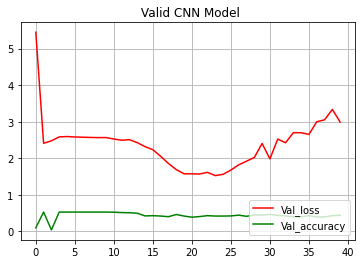

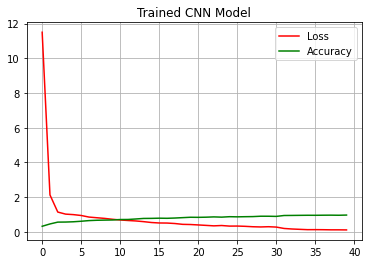

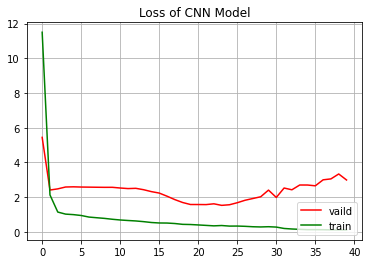

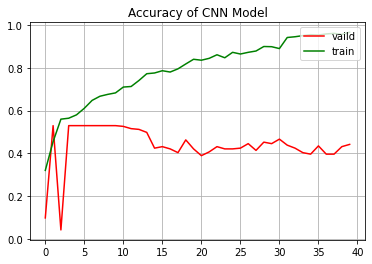

In [108]:
#전체 1424 개
classifier = model.fit(X_train, Y_train, batch_size=64, epochs=40, validation_split=0.2)
plt.figure()

plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['val_accuracy'], 'g')
plt.grid()
plt.title(' Valid CNN Model')
plt.legend(['Val_loss' ,'Val_accuracy'], loc='lower right')

plt.figure()
plt.plot(classifier.history['loss'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Trained CNN Model')
plt.legend(['Loss', 'Accuracy'], loc='upper right')


plt.figure()
plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['loss'], 'g')
plt.grid()
plt.title('Loss of CNN Model')
plt.legend(['vaild', 'train'], loc='lower right')

plt.figure()
plt.plot(classifier.history['val_accuracy'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Accuracy of CNN Model')
plt.legend(['vaild', 'train'], loc='upper right')


# test
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction = model.predict(X_test)

In [109]:
# test
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction = model.predict(X_test)

12/12 - 0s - loss: 3.9548 - accuracy: 0.2829 - 144ms/epoch - 12ms/step
테스트 정확도: 0.2829131782054901


In [110]:
# 16 32 32
img_height = 14
img_width = 17
model2 = Sequential()

model2.add(layers.BatchNormalization(input_shape=(img_height, img_width , 1)))
model2.add(layers.Conv2D(filters=16, kernel_size=(5, 5), padding="same", activation='relu'))

model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu'))

model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu'))

model2.add(AveragePooling2D(pool_size=(5, 5)))
model2.add(Flatten())

model2.add(layers.Dense(14, activation='softmax'))
model2.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model2.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_74 (Bat  (None, 14, 17, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_78 (Conv2D)          (None, 14, 17, 16)        416       
                                                                 
 batch_normalization_75 (Bat  (None, 14, 17, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_79 (Conv2D)          (None, 14, 17, 32)        12832     
                                                                 
 batch_normalization_76 (Bat  (None, 14, 17, 32)       128       
 chNormalization)                                                
                                                     

Epoch 1/40
18/18 [==============================] - 4s 185ms/step - loss: 3.0108 - accuracy: 0.3626 - val_loss: 18.6463 - val_accuracy: 0.0772
Epoch 2/40
18/18 [==============================] - 3s 176ms/step - loss: 1.3453 - accuracy: 0.5241 - val_loss: 8.4204 - val_accuracy: 0.1930
Epoch 3/40
18/18 [==============================] - 3s 174ms/step - loss: 1.2023 - accuracy: 0.5399 - val_loss: 1.6721 - val_accuracy: 0.5579
Epoch 4/40
18/18 [==============================] - 4s 213ms/step - loss: 1.1500 - accuracy: 0.5478 - val_loss: 2.1076 - val_accuracy: 0.3298
Epoch 5/40
18/18 [==============================] - 5s 255ms/step - loss: 1.1076 - accuracy: 0.5558 - val_loss: 1.5275 - val_accuracy: 0.5053
Epoch 6/40
18/18 [==============================] - 5s 297ms/step - loss: 1.1016 - accuracy: 0.5496 - val_loss: 1.5427 - val_accuracy: 0.4667
Epoch 7/40
18/18 [==============================] - 5s 294ms/step - loss: 1.0706 - accuracy: 0.5637 - val_loss: 1.4431 - val_accuracy: 0.4105
Epoch

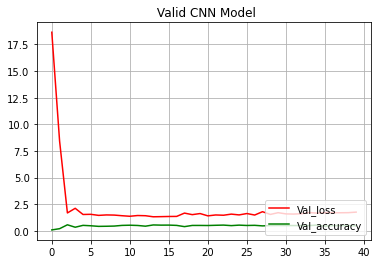

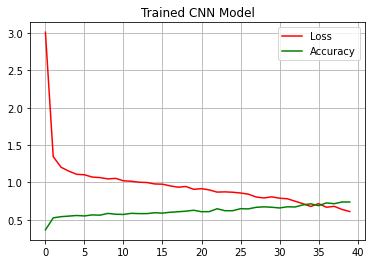

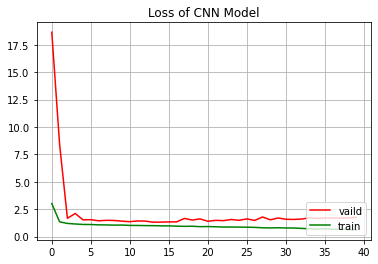

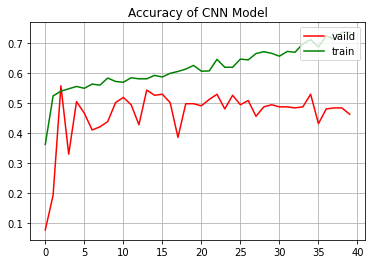

In [111]:
#전체 1424 개
classifier2 = model2.fit(X_train, Y_train, batch_size=64, epochs=40, validation_split=0.2)
plt.figure()

plt.plot(classifier2.history['val_loss'], 'r')
plt.plot(classifier2.history['val_accuracy'], 'g')
plt.grid()
plt.title(' Valid CNN Model')
plt.legend(['Val_loss' ,'Val_accuracy'], loc='lower right')

plt.figure()
plt.plot(classifier2.history['loss'], 'r')
plt.plot(classifier2.history['accuracy'], 'g')
plt.grid()
plt.title('Trained CNN Model')
plt.legend(['Loss', 'Accuracy'], loc='upper right')


plt.figure()
plt.plot(classifier2.history['val_loss'], 'r')
plt.plot(classifier2.history['loss'], 'g')
plt.grid()
plt.title('Loss of CNN Model')
plt.legend(['vaild', 'train'], loc='lower right')

plt.figure()
plt.plot(classifier2.history['val_accuracy'], 'r')
plt.plot(classifier2.history['accuracy'], 'g')
plt.grid()
plt.title('Accuracy of CNN Model')
plt.legend(['vaild', 'train'], loc='upper right')


# test
test_loss, test_acc = model2.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction2 = model2.predict(X_test)

In [112]:
# test
test_loss, test_acc = model2.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction2 = model2.predict(X_test)

12/12 - 0s - loss: 1.7265 - accuracy: 0.5714 - 238ms/epoch - 20ms/step
테스트 정확도: 0.5714285969734192


In [113]:
# 16 32 64
img_height = 14
img_width = 17
model3 = Sequential()

model3.add(layers.BatchNormalization(input_shape=(img_height, img_width , 1)))
model3.add(layers.Conv2D(filters=16, kernel_size=(5, 5), padding="same", activation='relu'))

model3.add(layers.BatchNormalization())
model3.add(layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu'))

model3.add(layers.BatchNormalization())
model3.add(layers.Conv2D(filters=64, kernel_size=(5, 5), padding="same", activation='relu'))

model3.add(AveragePooling2D(pool_size=(5, 5)))
model3.add(Flatten())

model3.add(layers.Dense(14, activation='softmax'))
model3.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model3.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_77 (Bat  (None, 14, 17, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_81 (Conv2D)          (None, 14, 17, 16)        416       
                                                                 
 batch_normalization_78 (Bat  (None, 14, 17, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_82 (Conv2D)          (None, 14, 17, 32)        12832     
                                                                 
 batch_normalization_79 (Bat  (None, 14, 17, 32)       128       
 chNormalization)                                                
                                                     

Epoch 1/40
18/18 [==============================] - 5s 234ms/step - loss: 3.9651 - accuracy: 0.3696 - val_loss: 17.8766 - val_accuracy: 0.2737
Epoch 2/40
18/18 [==============================] - 4s 218ms/step - loss: 1.3854 - accuracy: 0.5127 - val_loss: 7.2823 - val_accuracy: 0.0702
Epoch 3/40
18/18 [==============================] - 4s 218ms/step - loss: 1.2054 - accuracy: 0.5373 - val_loss: 3.5378 - val_accuracy: 0.2070
Epoch 4/40
18/18 [==============================] - 4s 216ms/step - loss: 1.1711 - accuracy: 0.5285 - val_loss: 3.0286 - val_accuracy: 0.2421
Epoch 5/40
18/18 [==============================] - 4s 217ms/step - loss: 1.1199 - accuracy: 0.5391 - val_loss: 2.3295 - val_accuracy: 0.3228
Epoch 6/40
18/18 [==============================] - 4s 218ms/step - loss: 1.0802 - accuracy: 0.5672 - val_loss: 1.9578 - val_accuracy: 0.4561
Epoch 7/40
18/18 [==============================] - 4s 217ms/step - loss: 1.0569 - accuracy: 0.5593 - val_loss: 1.4035 - val_accuracy: 0.4211
Epoch

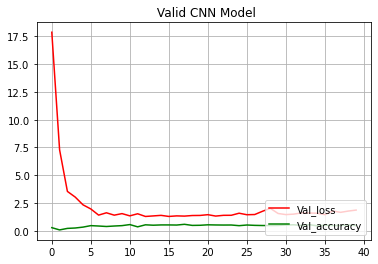

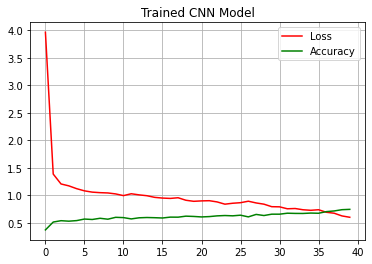

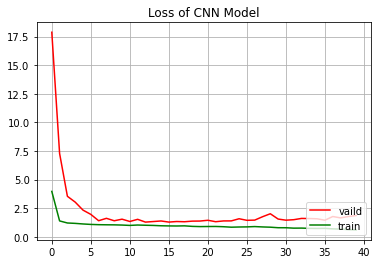

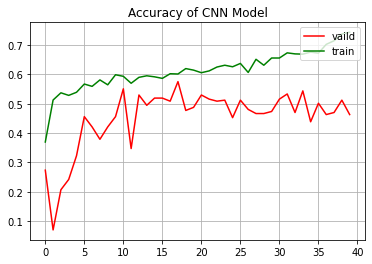

In [114]:
#전체 1424 개
classifier3 = model3.fit(X_train, Y_train, batch_size=64, epochs=40, validation_split=0.2)
plt.figure()

plt.plot(classifier3.history['val_loss'], 'r')
plt.plot(classifier3.history['val_accuracy'], 'g')
plt.grid()
plt.title(' Valid CNN Model')
plt.legend(['Val_loss' ,'Val_accuracy'], loc='lower right')

plt.figure()
plt.plot(classifier3.history['loss'], 'r')
plt.plot(classifier3.history['accuracy'], 'g')
plt.grid()
plt.title('Trained CNN Model')
plt.legend(['Loss', 'Accuracy'], loc='upper right')


plt.figure()
plt.plot(classifier3.history['val_loss'], 'r')
plt.plot(classifier3.history['loss'], 'g')
plt.grid()
plt.title('Loss of CNN Model')
plt.legend(['vaild', 'train'], loc='lower right')

plt.figure()
plt.plot(classifier3.history['val_accuracy'], 'r')
plt.plot(classifier3.history['accuracy'], 'g')
plt.grid()
plt.title('Accuracy of CNN Model')
plt.legend(['vaild', 'train'], loc='upper right')


# test
test_loss, test_acc = model3.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction3 = model3.predict(X_test)

In [124]:
from sklearn.metrics import f1_score
print('\n-----micro f1 score : ', f1_score(np.argmax(Y_test, 1), np.argmax(prediction3, 1), average='micro'))


-----micro f1 score :  0.28851540616246496


# Epoch를 늘려보자

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_80 (Bat  (None, 14, 17, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_84 (Conv2D)          (None, 14, 17, 16)        416       
                                                                 
 batch_normalization_81 (Bat  (None, 14, 17, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_85 (Conv2D)          (None, 14, 17, 32)        12832     
                                                                 
 batch_normalization_82 (Bat  (None, 14, 17, 32)       128       
 chNormalization)                                                
                                                     

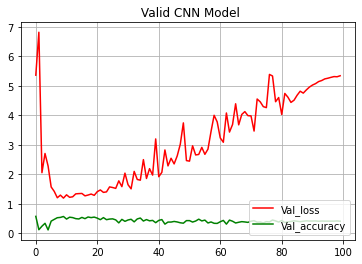

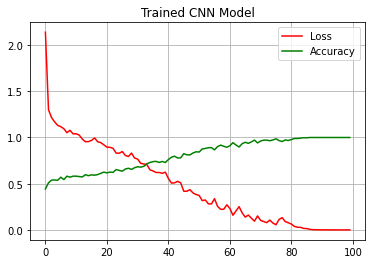

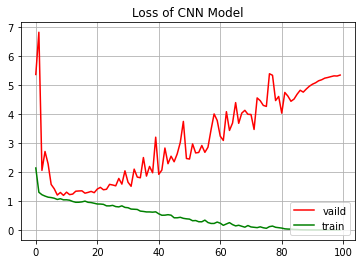

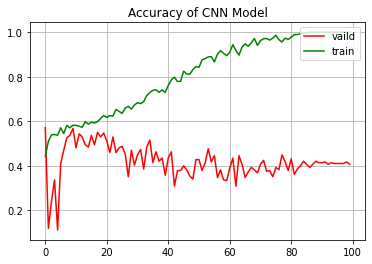

In [126]:
# 16 32 32
img_height = 14
img_width = 17
model2 = Sequential()

model2.add(layers.BatchNormalization(input_shape=(img_height, img_width , 1)))
model2.add(layers.Conv2D(filters=16, kernel_size=(5, 5), padding="same", activation='relu'))

model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu'))

model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu'))

model2.add(AveragePooling2D(pool_size=(5, 5)))
model2.add(Flatten())

model2.add(layers.Dense(14, activation='softmax'))
model2.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model2.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])

#전체 1424 개
classifier2 = model2.fit(X_train, Y_train, batch_size=64, epochs=100, validation_split=0.2)
plt.figure()

plt.plot(classifier2.history['val_loss'], 'r')
plt.plot(classifier2.history['val_accuracy'], 'g')
plt.grid()
plt.title(' Valid CNN Model')
plt.legend(['Val_loss' ,'Val_accuracy'], loc='lower right')

plt.figure()
plt.plot(classifier2.history['loss'], 'r')
plt.plot(classifier2.history['accuracy'], 'g')
plt.grid()
plt.title('Trained CNN Model')
plt.legend(['Loss', 'Accuracy'], loc='upper right')


plt.figure()
plt.plot(classifier2.history['val_loss'], 'r')
plt.plot(classifier2.history['loss'], 'g')
plt.grid()
plt.title('Loss of CNN Model')
plt.legend(['vaild', 'train'], loc='lower right')

plt.figure()
plt.plot(classifier2.history['val_accuracy'], 'r')
plt.plot(classifier2.history['accuracy'], 'g')
plt.grid()
plt.title('Accuracy of CNN Model')
plt.legend(['vaild', 'train'], loc='upper right')


# test
test_loss, test_acc = model2.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

In [127]:
# test
test_loss, test_acc = model2.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

12/12 - 0s - loss: 5.1402 - accuracy: 0.3669 - 245ms/epoch - 20ms/step
테스트 정확도: 0.3669467866420746


Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_86 (Bat  (None, 14, 17, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_90 (Conv2D)          (None, 14, 17, 16)        416       
                                                                 
 batch_normalization_87 (Bat  (None, 14, 17, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_91 (Conv2D)          (None, 14, 17, 32)        12832     
                                                                 
 batch_normalization_88 (Bat  (None, 14, 17, 32)       128       
 chNormalization)                                                
                                                     

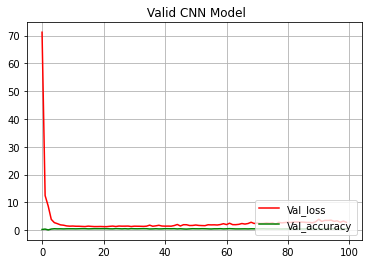

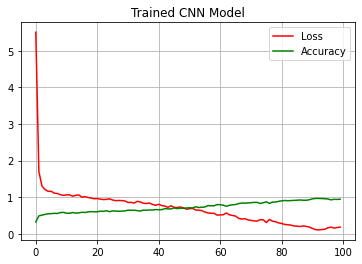

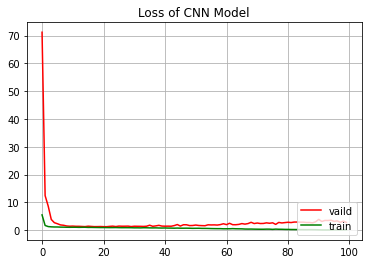

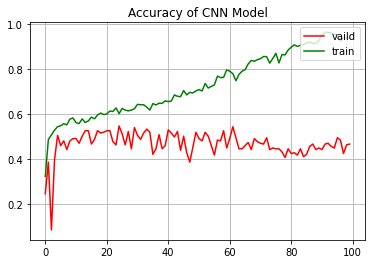

In [129]:
# 16 32 64
img_height = 14
img_width = 17
model3 = Sequential()

model3.add(layers.BatchNormalization(input_shape=(img_height, img_width , 1)))
model3.add(layers.Conv2D(filters=16, kernel_size=(5, 5), padding="same", activation='relu'))

model3.add(layers.BatchNormalization())
model3.add(layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu'))

model3.add(layers.BatchNormalization())
model3.add(layers.Conv2D(filters=64, kernel_size=(5, 5), padding="same", activation='relu'))

model3.add(AveragePooling2D(pool_size=(5, 5)))
model3.add(Flatten())

model3.add(layers.Dense(14, activation='softmax'))
model3.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model3.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])

#전체 1424 개
classifier3 = model3.fit(X_train, Y_train, batch_size=64, epochs=100, validation_split=0.2)
plt.figure()

plt.plot(classifier3.history['val_loss'], 'r')
plt.plot(classifier3.history['val_accuracy'], 'g')
plt.grid()
plt.title(' Valid CNN Model')
plt.legend(['Val_loss' ,'Val_accuracy'], loc='lower right')

plt.figure()
plt.plot(classifier3.history['loss'], 'r')
plt.plot(classifier3.history['accuracy'], 'g')
plt.grid()
plt.title('Trained CNN Model')
plt.legend(['Loss', 'Accuracy'], loc='upper right')


plt.figure()
plt.plot(classifier3.history['val_loss'], 'r')
plt.plot(classifier3.history['loss'], 'g')
plt.grid()
plt.title('Loss of CNN Model')
plt.legend(['vaild', 'train'], loc='lower right')

plt.figure()
plt.plot(classifier3.history['val_accuracy'], 'r')
plt.plot(classifier3.history['accuracy'], 'g')
plt.grid()
plt.title('Accuracy of CNN Model')
plt.legend(['vaild', 'train'], loc='upper right')


# test
test_loss, test_acc = model3.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

In [135]:
# test
test_loss, test_acc = model3.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

12/12 - 0s - loss: 2.2354 - accuracy: 0.5966 - 304ms/epoch - 25ms/step
테스트 정확도: 0.5966386795043945


# DropOut적용

In [131]:
#Convolution - Batch Normalization - Activation - Dropout - Pooling

In [136]:
# 16 32 32
img_height = 14
img_width = 17
model = Sequential()

model.add(layers.BatchNormalization(input_shape=(img_height, img_width , 1)))
model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), padding="same", activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), padding="same", activation='relu'))

model.add(AveragePooling2D(pool_size=(5, 5)))
model.add(Flatten())

model.add(layers.Dense(14, activation='softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_92 (Bat  (None, 14, 17, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_96 (Conv2D)          (None, 14, 17, 16)        416       
                                                                 
 batch_normalization_93 (Bat  (None, 14, 17, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_97 (Conv2D)          (None, 14, 17, 32)        12832     
                                                                 
 dropout_2 (Dropout)         (None, 14, 17, 32)        0         
                                                                 
 batch_normalization_94 (Bat  (None, 14, 17, 32)     

Epoch 1/40
18/18 [==============================] - 8s 364ms/step - loss: 3.9426 - accuracy: 0.3749 - val_loss: 36.6630 - val_accuracy: 0.0421
Epoch 2/40
18/18 [==============================] - 5s 306ms/step - loss: 1.4214 - accuracy: 0.4996 - val_loss: 2.2156 - val_accuracy: 0.3649
Epoch 3/40
18/18 [==============================] - 4s 228ms/step - loss: 1.2116 - accuracy: 0.5478 - val_loss: 1.5627 - val_accuracy: 0.5088
Epoch 4/40
18/18 [==============================] - 4s 228ms/step - loss: 1.1520 - accuracy: 0.5531 - val_loss: 1.4902 - val_accuracy: 0.4526
Epoch 5/40
18/18 [==============================] - 4s 224ms/step - loss: 1.1378 - accuracy: 0.5435 - val_loss: 1.3394 - val_accuracy: 0.4526
Epoch 6/40
18/18 [==============================] - 4s 225ms/step - loss: 1.1360 - accuracy: 0.5478 - val_loss: 1.4722 - val_accuracy: 0.4737
Epoch 7/40
18/18 [==============================] - 4s 223ms/step - loss: 1.1164 - accuracy: 0.5637 - val_loss: 1.4994 - val_accuracy: 0.4877
Epoch

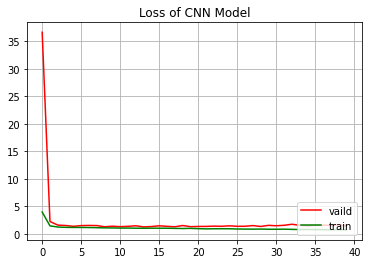

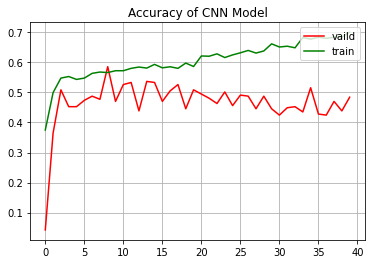

In [137]:
#전체 1424 개
classifier = model.fit(X_train, Y_train, batch_size=64, epochs=40, validation_split=0.2)


plt.figure()
plt.plot(classifier.history['val_loss'], 'r')
plt.plot(classifier.history['loss'], 'g')
plt.grid()
plt.title('Loss of CNN Model')
plt.legend(['vaild', 'train'], loc='lower right')

plt.figure()
plt.plot(classifier.history['val_accuracy'], 'r')
plt.plot(classifier.history['accuracy'], 'g')
plt.grid()
plt.title('Accuracy of CNN Model')
plt.legend(['vaild', 'train'], loc='upper right')


# test
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

In [138]:
# test
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('테스트 정확도:', test_acc)

12/12 - 0s - loss: 1.2145 - accuracy: 0.6022 - 302ms/epoch - 25ms/step
테스트 정확도: 0.6022409200668335


In [161]:
from google.colab import drive
drive.mount('/content/gdrive/') #기본적으로 필요한 위치입니다. 

# 아이디를 등록하면 코드를 부여하는데 복사해서 아래 생기는 칸에 붙여넣고 확인을 넣어줍니다.

!pwd 
%cd gdrive/'My Drive'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content
/content/gdrive/My Drive


In [163]:
from keras.models import load_model
model.save('my_model2.h5')

In [164]:
model.save_weights("test_save_weight")

In [165]:
import pandas as pd
hist_df = pd.DataFrame(classifier.history) 

# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [166]:
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)